# 决策树手动实现

In [112]:
#导入必要的库
import numpy as np
import pandas as pd
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder

## 数据集导入和处理

In [113]:
# 读取数据集
feature_names = ['Age','Workclass','fnlgwt','Education','EdNum','MaritalStatus','Occupation','Relationship','Race','Sex','CapitalGain','CapitalLoss','HoursPerWeek','Country','Income']

train = pd.read_csv('adult.data', names=feature_names)
test = pd.read_csv('adult.test', names=feature_names, skiprows=1)

In [114]:
# 数据删除与清洗
train.drop('fnlgwt', axis=1, inplace=True)
test.drop('fnlgwt', axis=1, inplace=True)

for i in train.columns:
    train[i].replace('?', 'Unknown', inplace=True)
    test[i].replace('?', 'Unknown', inplace=True)
    
    for col in train.columns:
        if train[col].dtype != 'int64':
           train[col] = train[col].apply(lambda val: val.replace(" ", ""))
           train[col] = train[col].apply(lambda val: val.replace(".", ""))
           test[col] = test[col].apply(lambda val: val.replace(" ", ""))
           test[col] = test[col].apply(lambda val: val.replace(".", ""))

train.drop(["Country", "Education"], axis=1, inplace=True)
test.drop(["Country", "Education"], axis=1, inplace=True)

C:\Users\hjhzjbs\AppData\Local\Temp\ipykernel_8700\1592468102.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[i].replace('?', 'Unknown', inplace=True)
C:\Users\hjhzjbs\AppData\Local\Temp\ipykernel_8700\1592468102.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

In [115]:
# 数据转化
colnames = list(train.columns)	
colnames.remove('Age')
colnames.remove('EdNum')
colnames = ['AgeGroup', 'EduGroup']+colnames

labels = ["{0}-{1}".format(i, i+9) for i in range(0,100,10)]

train['AgeGroup'] = pd.cut(train.Age, range(0,101,10), right = False, labels = 	labels) 
test['AgeGroup'] = pd.cut(test.Age, range(0,101,10), right = False, labels = 	labels) 

labels = ["{0}-{1}".format(i,i+4) for i in range(0,20,5)]    
train['EduGroup'] = pd.cut(train.EdNum, range(0,21,5), right = False, labels = 	labels)   
test['EduGroup'] = pd.cut(test.EdNum, range(0,21,5), right = False, labels = 	labels)

df_train_set = train[colnames] 
df_test_set = test[colnames]

In [116]:
# 重点部分
mapper = DataFrameMapper([('AgeGroup', LabelEncoder()),('EduGroup', LabelEncoder()),
                          ('Workclass', LabelEncoder()),('MaritalStatus', 			 								LabelEncoder()),
                          ('Occupation', LabelEncoder()),('Relationship', 											LabelEncoder()),
                          ('Race', LabelEncoder()),('Sex', LabelEncoder()),
                          ('Income', LabelEncoder())], df_out=True, default=None)

cols = list(df_train_set.columns)
cols.remove('Income')
cols = cols[:-3]+['Income']+cols[-3:] 

df_train = mapper.fit_transform(df_train_set.copy())
df_train.columns = cols
df_test = mapper.transform(df_test_set.copy())
df_test.columns = cols
cols.remove('Income')

x_train, y_train = df_train[cols].values, df_train['Income'].values
x_test, y_test = df_test[cols].values, df_test['Income'].values

## 决策树构建

In [117]:
# 计算信息熵
def calculate_entropy(labels):
    label_probabilities = np.unique(labels, return_counts=True)[1] / len(labels)
    ent = -np.sum(label_probabilities * np.log2(label_probabilities))               
        
    return ent

# 计算信息增益(ID3)
def ID3(data, labels, feature):
    total_entropy = calculate_entropy(labels)
    values, counts = np.unique(data[feature], return_counts=True)
    weights = counts / len(data)
    conditional_entropy = 0
    
    for value, weight in zip(values, weights):
        sub_labels = labels[data[feature] == value]
        conditional_entropy += weight * calculate_entropy(sub_labels)
        
    gain = total_entropy - conditional_entropy
    # print("ID3:", feature, gain)
    return gain

# 计算信息增益率(C4.5)
def C45(data, labels, feature):
    total_entropy = calculate_entropy(labels)
    values, counts = np.unique(data[feature], return_counts=True)
    weights = counts / len(data)
    conditional_entropy = 0
    split_info = 0
    
    for value, weight in zip(values, weights):
        sub_labels = labels[data[feature] == value]
        conditional_entropy += weight * calculate_entropy(sub_labels)
        split_info -= weight * np.log2(weight)
        
    gain_ratio = (total_entropy - conditional_entropy) / split_info
    # print("C45", feature, gain_ratio)
    return gain_ratio

# 计算基尼指数(CART)
def CART(data, labels, feature):
    values, counts = np.unique(data[feature], return_counts=True)
    weights = counts / len(data[feature])
    gini_index = 0
    
    for value, weight in zip(values, weights):
        sub_labels = labels[data[feature] == value]
        sub_label_probabilities = np.unique(sub_labels, return_counts=True)[1] / len(sub_labels)
        gini = 1 - np.sum(np.square(sub_label_probabilities))
        gini_index += weight * gini
    
    # print("CART", feature, gini_index)
    return 1 - gini_index               # 基尼指数越小越有利于分类

# 选择最佳特征
def choose_best_feature(data, labels, features, method=ID3):
    best_feature = features[0]
    best_score = 0
    
    for feature in features:
        score = method(data, labels, feature)
        if score > best_score:
            best_feature, best_score = feature, score

    return best_feature

# 构建决策树
def build_decision_tree(data, labels, features, depth=0, max_depth=10, method=ID3):
    if len(np.unique(labels)) == 1 or depth == max_depth or len(features) == 0:
        return np.unique(labels)[0]
    
    best_feature = choose_best_feature(data, labels, features, method)
    tree = {best_feature: {}}
    new_features = [i for i in features if i != best_feature]
    
    # print("Features:", features)
    # print("Best feature:", best_feature)
    for value in np.unique(data[best_feature]):
        # print("Value:", value)
        sub_data = data[data[best_feature] == value]
        sub_labels = labels[data[best_feature] == value]
        tree[best_feature][value] = build_decision_tree(sub_data, sub_labels, new_features, depth + 1, max_depth, method)
    
    return tree

## 训练、预测和可视化

In [118]:
x_train = pd.DataFrame(x_train)
x_test = pd.DataFrame(x_test)

In [119]:
# 训练
tree_ID3 = build_decision_tree(x_train, y_train, list(x_train.columns), depth=0, max_depth=10, method=ID3)
tree_C45 = build_decision_tree(x_train, y_train, list(x_train.columns), depth=0, max_depth=10, method=C45)
tree_CART = build_decision_tree(x_train, y_train, list(x_train.columns), depth=0, max_depth=10, method=CART)

C:\Users\hjhzjbs\AppData\Local\Temp\ipykernel_8700\3192276464.py:36: RuntimeWarning: invalid value encountered in scalar divide
  gain_ratio = (total_entropy - conditional_entropy) / split_info


In [120]:
# 预测
def predict(tree, sample):
    if not isinstance(tree, dict):
        return tree
    
    feature = list(tree.keys())[0]
    value = sample[feature]
    
    if value in tree[feature]:
        subtree = tree[feature][value]
        return predict(subtree, sample)

    else:
        return "Not Found"
    
def calculate_accuracy(predictions, labels):
    return np.mean([predictions[i] == labels[i] for i in range(len(predictions))])

predictions_ID3 = [predict(tree_ID3, sample) for sample in x_test.values]
print(f'Accuracy of ID3 tree: {calculate_accuracy(predictions_ID3, y_test):.10f}')

predictions_C45 = [predict(tree_C45, sample) for sample in x_test.values]
print(f'Accuracy of C45 tree: {calculate_accuracy(predictions_C45, y_test):.10f}')

predictions_CART = [predict(tree_CART, sample) for sample in x_test.values]
print(f'Accuracy of CART tree: {calculate_accuracy(predictions_CART, y_test):.10f}')

Accuracy of ID3 tree: 0.7659705160
Accuracy of C45 tree: 0.7725429975
Accuracy of CART tree: 0.7630221130


# 进一步实现随机森林分类器(Bagging)

## 随机森林构建

In [121]:
# 随机采样生成训练样本
def bootstrap_sample(data, labels, sample_num, feature_num):
    # 有放回随机采样
    sample_indices = np.random.choice(data.shape[0], sample_num, replace=True)
    data_sample = data.iloc[sample_indices]
    label_sample = labels[sample_indices]
    
    # 裁切样本
    feature_indices = np.random.choice(data.shape[1], feature_num, replace=False)
    data_sample = data_sample.iloc[:, feature_indices]
    
    return data_sample, label_sample

# 随机森林训练
def build_random_forest(data, labels, sample_num, feature_num, forest_size, max_depth=10, method=ID3):
    forest = []
    for i in range(forest_size):
        data_sample, label_sample = bootstrap_sample(data, labels, sample_num, feature_num)
        tree = build_decision_tree(data_sample, label_sample, list(data_sample.columns), max_depth=max_depth, method=method)
        forest.append(tree)
        
    return forest

In [122]:
# 训练
sample_num = 200
feature_num = int(np.sqrt(len(x_train.columns)))
forest_size = 100

forest_ID3 = build_random_forest(x_train, y_train, sample_num, feature_num, forest_size, max_depth=10, method=ID3)
forest_C45 = build_random_forest(x_train, y_train, sample_num, feature_num, forest_size, max_depth=10, method=C45)
forest_CART = build_random_forest(x_train, y_train, sample_num, feature_num, forest_size, max_depth=10, method=CART)

C:\Users\hjhzjbs\AppData\Local\Temp\ipykernel_8700\3192276464.py:36: RuntimeWarning: invalid value encountered in scalar divide
  gain_ratio = (total_entropy - conditional_entropy) / split_info


In [123]:
# 相对多数投票聚合预测器
from collections import Counter
def ramdom_forest_predict(forest, sample):
    predictions = [predict(tree, sample) for tree in forest]
    aggregating_predictions = Counter(predictions).most_common()[0][0]
    
    return aggregating_predictions

predictions_forest_ID3 = [ramdom_forest_predict(forest_ID3, sample) for sample in x_test.values]
print(f'Accuracy of ID3 forest: {calculate_accuracy(predictions_forest_ID3, y_test):.10f}')

predictions_forest_C45 = [ramdom_forest_predict(forest_C45, sample) for sample in x_test.values]
print(f'Accuracy of C45 forest: {calculate_accuracy(predictions_forest_C45, y_test):.10f}')

predictions_forest_CART = [ramdom_forest_predict(forest_CART, sample) for sample in x_test.values]
print(f'Accuracy of CART forest: {calculate_accuracy(predictions_forest_CART, y_test):.10f}')

Accuracy of ID3 forest: 0.7636977887
Accuracy of C45 forest: 0.7618550369
Accuracy of CART forest: 0.7635135135


# 探究基学习器数量和随机属性选取数量对随机森林的影响（以ID3算法为例）

In [124]:
sample_num = 200
feature_num = int(np.sqrt(len(x_train.columns)))
forest_sizes = [1,2,3,4] + [5*(i+1) for i in range(20)]

accuracies1 = []
accuracies2 = []

for forest_size in forest_sizes:
    forest = build_random_forest(x_train, y_train, sample_num, feature_num, forest_size, max_depth=10, method=ID3)
    predictions = [ramdom_forest_predict(forest, sample) for sample in x_test.values]
    accuracy = calculate_accuracy(predictions, y_test)
    accuracies1.append(accuracy)
    print(f'Accuracy when feature_num is {feature_num}, forest_size is {forest_size}: {accuracy}')
   
feature_num = int(np.log2(len(x_train.columns)))    
for forest_size in forest_sizes:
    forest = build_random_forest(x_train, y_train, sample_num, feature_num, forest_size, max_depth=10, method=ID3)
    predictions = [ramdom_forest_predict(forest, sample) for sample in x_test.values]
    accuracy = calculate_accuracy(predictions, y_test)
    accuracies2.append(accuracy)
    print(f'Accuracy when feature_num is {feature_num}, forest_size is {forest_size}: {accuracy}')

Accuracy when feature_num is 3, forest_size is 1: 0.7707616707616708
Accuracy when feature_num is 3, forest_size is 2: 0.65
Accuracy when feature_num is 3, forest_size is 3: 0.750061425061425
Accuracy when feature_num is 3, forest_size is 4: 0.7554668304668305
Accuracy when feature_num is 3, forest_size is 5: 0.7758599508599509
Accuracy when feature_num is 3, forest_size is 10: 0.7643120393120393
Accuracy when feature_num is 3, forest_size is 15: 0.7381449631449631
Accuracy when feature_num is 3, forest_size is 20: 0.7627149877149877
Accuracy when feature_num is 3, forest_size is 25: 0.7635749385749385
Accuracy when feature_num is 3, forest_size is 30: 0.7618550368550369
Accuracy when feature_num is 3, forest_size is 35: 0.7623464373464374
Accuracy when feature_num is 3, forest_size is 40: 0.7646191646191646
Accuracy when feature_num is 3, forest_size is 45: 0.7641277641277642
Accuracy when feature_num is 3, forest_size is 50: 0.7636977886977887
Accuracy when feature_num is 3, forest_s

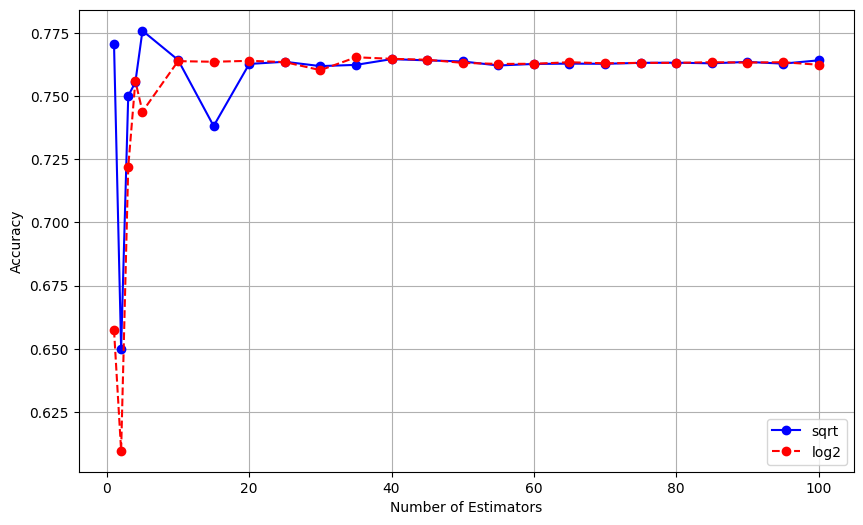

In [125]:
# 可视化结果
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(forest_sizes, accuracies1, marker='o', linestyle='-', color='b')
plt.plot(forest_sizes, accuracies2, marker='o', linestyle='--', color='r')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.legend(['sqrt','log2'])
plt.grid(True)
plt.show()